In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall, AUC


In [2]:
SEED = 42
NUM_EPOCHS = 5
TARGET_LABEL = "dx"
BALANCE_LABEL = "dx"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

In [3]:
FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/bjzim-models/'  # Replace with your folder path

In [4]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

In [5]:
import os

log_dir = "./tensorboard_logs"
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

In [6]:
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [7]:
%load_ext tensorboard

## Checking if validation/ test data are not augmented

In [8]:
# Überprüfung für validation_df
if any(validation_df['image_id'].str.startswith('aug_')):
    print("Warnung: Augmentierte Daten im Validierungsset gefunden.")

# Überprüfung für test_df
if any(test_df['image_id'].str.startswith('aug_')):
    print("Warnung: Augmentierte Daten im Testset gefunden.")


## Define Callbacks for Model

In [9]:
# EarlyStopping-Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik, die überwacht wird
    patience=10,         # Anzahl der Epochen ohne Verbesserung
    verbose=1,           # Ausgabe-Steuerung
    restore_best_weights=True  # Die besten Gewichtungen wiederherstellen
)

In [10]:
# ReduceLROnPlateau-Callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metrik, die überwacht wird
    factor=0.1,          # Faktor, um die Lernrate zu reduzieren
    patience=5,          # Anzahl der Epochen ohne Verbesserung
    verbose=1,           # Ausgabe-Steuerung
    min_lr=1e-6          # Minimale Lernrate
)

## **Build Model:**

In [11]:
# Initialize the MobileNetV3Large model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Unfreeze some of the layers for fine-tuning
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True


# Add custom layers on top
x = layers.Conv2D(128, (3, 3), activation='relu')(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)


# Create the full model
model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_pretrained-weights_fixed-layers_custom-conv2D")


2023-10-05 03:53:24.046617: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-10-05 03:53:24.046644: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-10-05 03:53:24.046648: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-10-05 03:53:24.047106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-05 03:53:24.047128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## GridSearch: Data Preprocessing and Augmentation, Model

In [12]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import load_model
import os

# Beste Metrik initialisieren
best_val_recall = 0.0
best_params = None
best_model_path = "best_model_recall.h5"

# Definiere die Parameter für die Grid-Suche
param_grid = {
    'rotation_range': [20],
    'width_shift_range': [0.1],
    'height_shift_range': [0.1],
    'zoom_range': [0.1],
    'horizontal_flip': [True],
    'vertical_flip': [True],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [128, 64]
}

# Erstelle eine Liste aller Kombinationen der Hyperparameter
grid = ParameterGrid(param_grid)
total_iterations = len(grid)  # Gesamtanzahl der Iterationen
iteration = 1  # Aktuelle Iteration

# Durchlaufe jede Kombination der Hyperparameter
for params in grid:
    print(f"Training with params: {params}")
    print(f"Iteration {iteration} of {total_iterations}")
    
    # Definiere den TensorBoard-Log-Pfad für diese Hyperparameter-Kombination
    log_dir = f"./tensorboard_logs/{params}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Erstelle einen neuen ImageDataGenerator mit den aktuellen Parametern
    datagen_train = ImageDataGenerator(
        rescale=1.0 / 255.0,
        preprocessing_function=preprocess_input,
        rotation_range=params['rotation_range'],
        width_shift_range=params['width_shift_range'],
        height_shift_range=params['height_shift_range'],
        zoom_range=params['zoom_range'],
        horizontal_flip=params['horizontal_flip'],
        vertical_flip=params['vertical_flip'],
        fill_mode='nearest'
    )
    
    train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=params['batch_size']
    )
    
    datagen_validation = ImageDataGenerator(
        rescale=1.0 / 255.0, #see above
        preprocessing_function=preprocess_input
    )

    validation_generator = datagen_validation.flow_from_dataframe(
        dataframe=validation_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=params['batch_size']
    )

    # Compile the model
    # Ältere Version des Adam-Optimierers für M1/M2 Macs
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc')
        ]
    )  

    # Trainiere das Modell mit den aktuellen Data Augmentation Parametern
    # (Der Rest des Trainingscodes bleibt gleich)
    # Train the model

    history = model.fit(
        train_data_generator,
        epochs=NUM_EPOCHS,
        verbose=1,                      # Adjust verbosity level
        batch_size=params['batch_size'],                # Set the batch size, default is 32, can be increased to speed up training, but memory consumption increases
        callbacks=[early_stopping, reduce_lr, tensorboard_callback],                 # List of callbacks to apply during training
        validation_split=0.0,           # not needed as we use a validation data generator
        validation_data=validation_generator,
        shuffle=True,                   # Shuffle the training data before each epoch
        sample_weight=None,             # Set the weights for the train data set !
        class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
        initial_epoch=0,                # Use this to continue training from a specific epoch
        steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
        validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
        validation_batch_size=None,     # Set the batch size for validation, default is batch_size
        validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
        max_queue_size=10,              # Set the max size for the generator queue
        workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
        use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
    )

    # Überprüfe, ob dieses Modell besser ist als das bisher beste
    final_val_recall = history.history['val_recall'][-1]
    if final_val_recall > best_val_recall:
        print(f"New best model found! val_recall: {final_val_recall}")
        best_val_recall = final_val_recall
        best_params = params

        # Speichere das beste Modell
        model.save(best_model_path)

    iteration += 1  # Aktualisiere die Iterationszählung



Training with params: {'batch_size': 128, 'height_shift_range': 0.1, 'horizontal_flip': True, 'learning_rate': 0.01, 'rotation_range': 20, 'vertical_flip': True, 'width_shift_range': 0.1, 'zoom_range': 0.1}
Iteration 1 of 6
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/5


2023-10-05 03:53:35.355419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 2.2182 - accuracy: 0.1368 - precision: 0.1633 - recall: 0.0091 - auc: 0.4923

2023-10-05 03:55:17.205940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 141s 3s/step - loss: 2.2182 - accuracy: 0.1368 - precision: 0.1633 - recall: 0.0091 - auc: 0.4923 - val_loss: 10223462400.0000 - val_accuracy: 0.0509 - val_precision: 0.0509 - val_recall: 0.0509 - val_auc: 0.4464 - lr: 0.0100
Epoch 2/5
42/42 [==============================] - 75s 2s/step - loss: 2.1416 - accuracy: 0.1366 - precision: 0.1288 - recall: 0.0040 - auc: 0.4996 - val_loss: 495729728.0000 - val_accuracy: 0.0115 - val_precision: 0.0115 - val_recall: 0.0115 - val_auc: 0.4234 - lr: 0.0100
Epoch 3/5
42/42 [==============================] - 80s 2s/step - loss: 2.0061 - accuracy: 0.1847 - precision: 0.1589 - recall: 0.0032 - auc: 0.5856 - val_loss: 35203272.0000 - val_accuracy: 0.0115 - val_precision: 0.0115 - val_recall: 0.0115 - val_auc: 0.4234 - lr: 0.0100
Epoch 4/5
42/42 [==============================] - 84s 2s/step - loss: 1.8649 - accuracy: 0.2416 - precision: 0.3093 - recall: 0.0139 - auc: 0.6950 - val_loss: 6419724.5000 - val_accurac

/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training with params: {'batch_size': 128, 'height_shift_range': 0.1, 'horizontal_flip': True, 'learning_rate': 0.001, 'rotation_range': 20, 'vertical_flip': True, 'width_shift_range': 0.1, 'zoom_range': 0.1}
Iteration 2 of 6
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/5


2023-10-05 04:01:19.622838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 1.7732 - accuracy: 0.2567 - precision: 0.2663 - recall: 0.0086 - auc: 0.7175

2023-10-05 04:03:10.122309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 154s 3s/step - loss: 1.7732 - accuracy: 0.2567 - precision: 0.2663 - recall: 0.0086 - auc: 0.7175 - val_loss: 1523747.2500 - val_accuracy: 0.0115 - val_precision: 0.0115 - val_recall: 0.0115 - val_auc: 0.4234 - lr: 0.0010
Epoch 2/5
42/42 [==============================] - 81s 2s/step - loss: 1.7235 - accuracy: 0.2626 - precision: 0.3372 - recall: 0.0110 - auc: 0.7258 - val_loss: 238447.1562 - val_accuracy: 0.0509 - val_precision: 0.0509 - val_recall: 0.0509 - val_auc: 0.4464 - lr: 0.0010
Epoch 3/5
42/42 [==============================] - 90s 2s/step - loss: 1.7184 - accuracy: 0.2732 - precision: 0.3526 - recall: 0.0127 - auc: 0.7295 - val_loss: 225505.0938 - val_accuracy: 0.0115 - val_precision: 0.0115 - val_recall: 0.0115 - val_auc: 0.4234 - lr: 0.0010
Epoch 4/5
42/42 [==============================] - 89s 2s/step - loss: 1.6814 - accuracy: 0.2928 - precision: 0.4360 - recall: 0.0175 - auc: 0.7391 - val_loss: 128921.7422 - val_accuracy: 0.0115 

2023-10-05 04:09:41.237539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 1.6647 - accuracy: 0.3116 - precision: 0.4506 - recall: 0.0217 - auc: 0.7505

2023-10-05 04:11:41.662111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 162s 3s/step - loss: 1.6647 - accuracy: 0.3116 - precision: 0.4506 - recall: 0.0217 - auc: 0.7505 - val_loss: 23363.0332 - val_accuracy: 0.0145 - val_precision: 0.0145 - val_recall: 0.0145 - val_auc: 0.4251 - lr: 1.0000e-04
Epoch 2/5
42/42 [==============================] - 82s 2s/step - loss: 1.6392 - accuracy: 0.3288 - precision: 0.4950 - recall: 0.0283 - auc: 0.7550 - val_loss: 10560.3750 - val_accuracy: 0.0145 - val_precision: 0.0145 - val_recall: 0.0145 - val_auc: 0.4251 - lr: 1.0000e-04
Epoch 3/5
42/42 [==============================] - 89s 2s/step - loss: 1.6356 - accuracy: 0.3290 - precision: 0.5137 - recall: 0.0322 - auc: 0.7560 - val_loss: 5606.0908 - val_accuracy: 0.0145 - val_precision: 0.0145 - val_recall: 0.0145 - val_auc: 0.4251 - lr: 1.0000e-04
Epoch 4/5
42/42 [==============================] - 90s 2s/step - loss: 1.6373 - accuracy: 0.3252 - precision: 0.5358 - recall: 0.0327 - auc: 0.7585 - val_loss: 3192.9583 - val_accuracy: 0.

2023-10-05 04:18:09.776255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 1.8481 - accuracy: 0.2460 - precision: 0.3261 - recall: 0.0171 - auc: 0.6962

2023-10-05 04:20:15.312307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 173s 2s/step - loss: 1.8481 - accuracy: 0.2460 - precision: 0.3261 - recall: 0.0171 - auc: 0.6962 - val_loss: 1060031.6250 - val_accuracy: 0.0330 - val_precision: 0.0330 - val_recall: 0.0330 - val_auc: 0.4359 - lr: 0.0100
Epoch 2/5
83/83 [==============================] - 78s 938ms/step - loss: 1.8248 - accuracy: 0.2508 - precision: 0.3463 - recall: 0.0204 - auc: 0.7007 - val_loss: 1748391808.0000 - val_accuracy: 0.0330 - val_precision: 0.0330 - val_recall: 0.0330 - val_auc: 0.4359 - lr: 0.0100
Epoch 3/5
83/83 [==============================] - 85s 1s/step - loss: 1.7271 - accuracy: 0.2688 - precision: 0.3541 - recall: 0.0141 - auc: 0.7225 - val_loss: 106956432.0000 - val_accuracy: 0.0115 - val_precision: 0.0115 - val_recall: 0.0115 - val_auc: 0.4234 - lr: 0.0100
Epoch 4/5
83/83 [==============================] - 92s 1s/step - loss: 1.6898 - accuracy: 0.2690 - precision: 0.3804 - recall: 0.0200 - auc: 0.7281 - val_loss: 4564838.5000 - val_accura

2023-10-05 04:26:48.170815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 1.6256 - accuracy: 0.3057 - precision: 0.4905 - recall: 0.0295 - auc: 0.7538

2023-10-05 04:29:08.778987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 192s 2s/step - loss: 1.6256 - accuracy: 0.3057 - precision: 0.4905 - recall: 0.0295 - auc: 0.7538 - val_loss: 20905.2598 - val_accuracy: 0.0115 - val_precision: 0.0115 - val_recall: 0.0115 - val_auc: 0.4234 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - 80s 953ms/step - loss: 1.6125 - accuracy: 0.3147 - precision: 0.4786 - recall: 0.0361 - auc: 0.7588 - val_loss: 489.8721 - val_accuracy: 0.0330 - val_precision: 0.0330 - val_recall: 0.0330 - val_auc: 0.4359 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - 83s 998ms/step - loss: 1.5889 - accuracy: 0.3213 - precision: 0.5584 - recall: 0.0491 - auc: 0.7656 - val_loss: 363.2979 - val_accuracy: 0.0115 - val_precision: 0.0115 - val_recall: 0.0115 - val_auc: 0.4234 - lr: 0.0010
Epoch 4/5
83/83 [==============================] - 86s 1s/step - loss: 1.5926 - accuracy: 0.3115 - precision: 0.5423 - recall: 0.0451 - auc: 0.7647 - val_loss: 179.3704 - val_accuracy: 0.0145 - val

2023-10-05 04:35:33.155740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 1.5670 - accuracy: 0.3316 - precision: 0.5655 - recall: 0.0575 - auc: 0.7733

2023-10-05 04:38:05.155465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 204s 2s/step - loss: 1.5670 - accuracy: 0.3316 - precision: 0.5655 - recall: 0.0575 - auc: 0.7733 - val_loss: 43.1444 - val_accuracy: 0.0145 - val_precision: 0.0145 - val_recall: 0.0145 - val_auc: 0.2248 - lr: 1.0000e-04
Epoch 2/5
83/83 [==============================] - 83s 998ms/step - loss: 1.5656 - accuracy: 0.3427 - precision: 0.5988 - recall: 0.0576 - auc: 0.7745 - val_loss: 8.2076 - val_accuracy: 0.0135 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1539 - lr: 1.0000e-04
Epoch 3/5
83/83 [==============================] - 88s 1s/step - loss: 1.5688 - accuracy: 0.3389 - precision: 0.5853 - recall: 0.0561 - auc: 0.7743 - val_loss: 3.2447 - val_accuracy: 0.0509 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1537 - lr: 1.0000e-04
Epoch 4/5
83/83 [==============================] - 86s 1s/step - loss: 1.5602 - accuracy: 0.3480 - precision: 0.5787 - recall: 0.0580 - auc: 0.7768 - val_loss: 2.6067 - val_accura

Best val_recall: 0.014478283002972603
Best params: {'batch_size': 128, 'height_shift_range': 0.1, 'horizontal_flip': True, 'learning_rate': 0.01, 'rotation_range': 20, 'vertical_flip': True, 'width_shift_range': 0.1, 'zoom_range': 0.1}
Best model path: best_model_recall.h5
Best model name: MobilneNetV3Large_pretrained-weights_fixed-layers_custom-conv2D
Best model optimizer: <keras.src.optimizers.legacy.adam.Adam object at 0x2c8ed09d0>
Best model metrics: ['loss', 'accuracy', 'precision', 'recall', 'auc']


2023-10-05 07:49:34.207843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 61s 1s/step - loss: 4795648.0000 - accuracy: 0.0145 - precision: 0.0145 - recall: 0.0145 - auc: 0.4251
Best model loss & metrics: [4795648.0, 0.014478283002972603, 0.014478283002972603, 0.014478283002972603, 0.42511236667633057]
Model: "MobilneNetV3Large_pretrained-weights_fixed-layers_custom-conv2D"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432  

2023-10-05 07:50:36.831777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 52s 1s/step


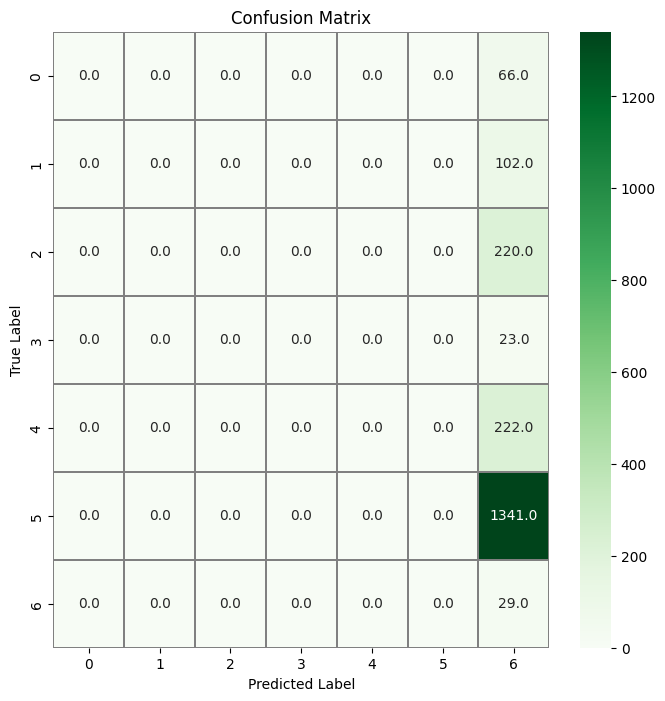

In [14]:
# Lade das beste Modell
best_model = load_model(best_model_path)


print(f"Best val_recall: {best_val_recall}")
print(f"Best params: {best_params}")
print(f"Best model path: {best_model_path}")
print(f"Best model name: {best_model.name}")
print(f"Best model optimizer: {best_model.optimizer}")
print(f"Best model metrics: {best_model.metrics_names}")
print(f"Best model loss & metrics: {best_model.evaluate(validation_generator)}")
print(f"Best model summary: {best_model.summary()}")
print(f"Best model layers: {best_model.layers}")
best_model_weights = best_model.get_weights()
print(f"Best model weights: {best_model_weights}")
print(f"Best model history: {best_model.history}")

# sns heatmap for confusion matrix of best model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict the values from the validation dataset
Y_pred = best_model.predict(validation_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = validation_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [15]:
%tensorboard --logdir ./tensorboard_logs --port 6007

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
W1005 07:52:17.502257 10958745600 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W1005 07:52:17.541352 10958745600 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Traceback (most recent call last):
  File "/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
             ^^^^^^^^^^
  File "/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/Users/bjz/neueFische/capstone/capstone-healt

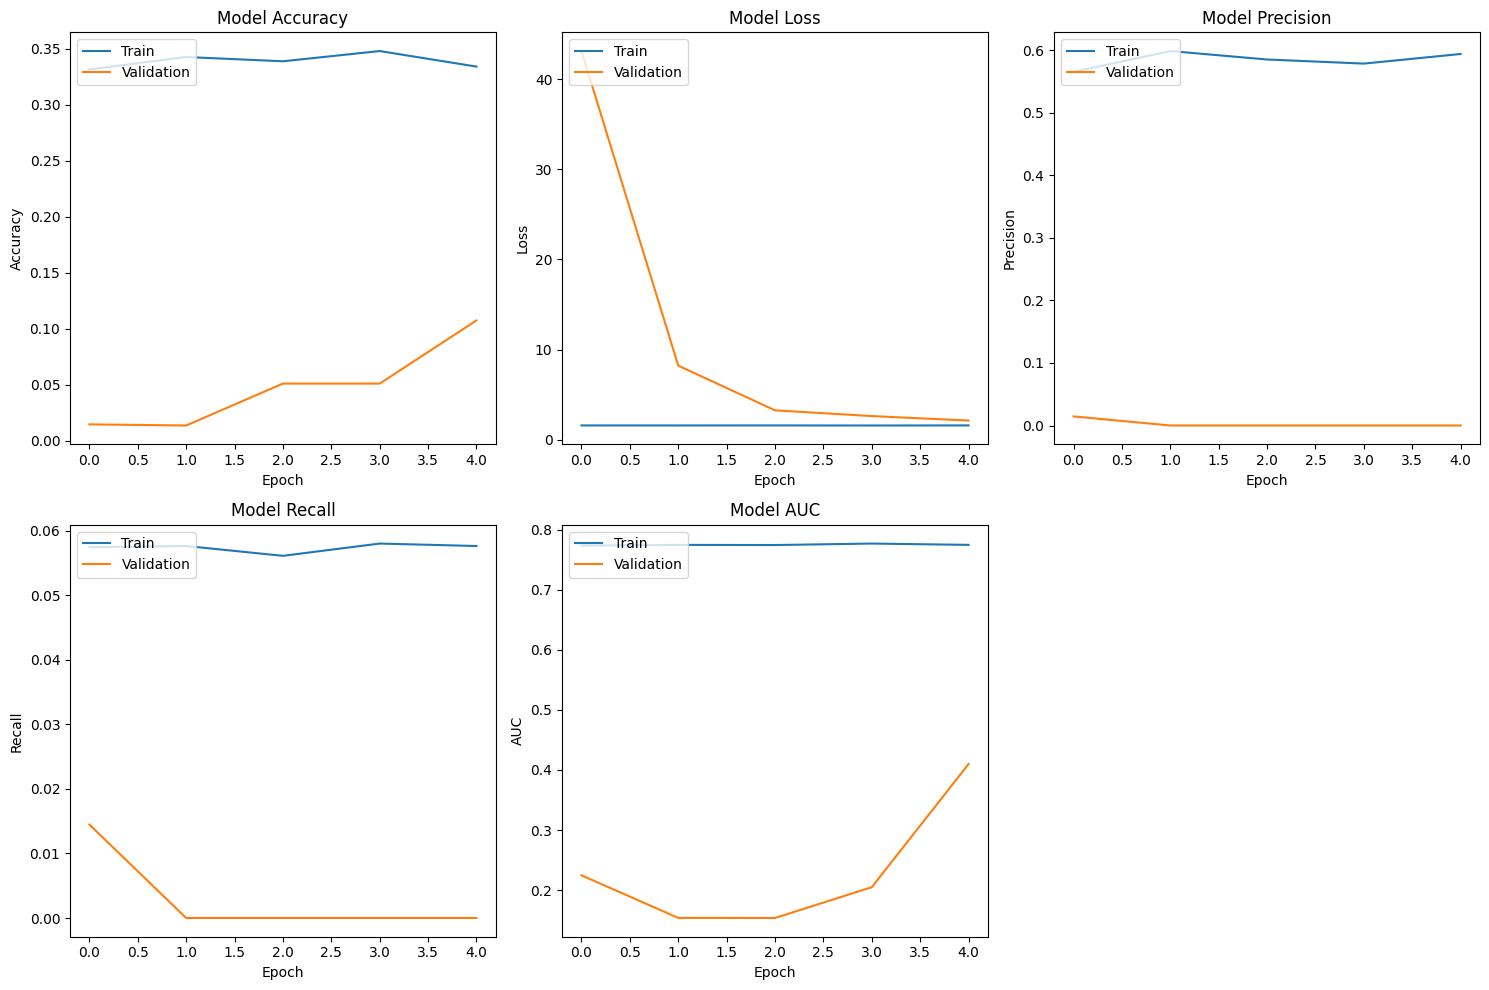

In [17]:
import matplotlib.pyplot as plt

# 'history' ist das Objekt, das von model.fit zurückgegeben wird
# Es enthält den Trainingsverlauf zum plotten

plt.figure(figsize=(15, 10))

# Accuracy plotten
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Verlust plotten
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Precision plotten
plt.subplot(2, 3, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')

# Recall plotten
plt.subplot(2, 3, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper left')

# AUC plotten
plt.subplot(2, 3, 5)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [18]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"{FILEPATH_OUTPUT}model_bjzim_MobileNetV3Large{timestamp}.h5"
model.save(model_path)



/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
